# 巡回セールスマン問題 (Traveling Salesman Problem; TSP)

1人のセールスマンが決められた地点を全て1度ずつ訪れて元の地点に戻ってくるための最短経路を探すのが巡回セールスマン問題(TSP)です。

![tsp_04.png](./images/tsp_04.png)

この問題は何も工夫をせずに全ての訪れる順番の可能性を総当たりで調べていくと、莫大な計算量になります。$N$個の地点があるとすると、最初の出発地点を選んだら次の地点の候補としては$N-1$通りです。そこからさらに次の地点の候補としては$N-2$通りです。これを繰り返していくと、この問題の訪れる順番の組み合わせの数は全部で

$$(N-1)(N-2) \cdots 2 \cdot 1 = (N-1)!$$

のようになります。$N=10$でも、この組合せはおよそ36万通りです。TSPはNP困難と呼ばれる、難しい問題のクラスに属することが知られています。

## 応用例: 配送計画問題 (Vehicle Routing Problem; VRP)

荷物の集積地(デポ)から各顧客へトラックで荷物を届ける際になるべくコスト(時間・距離など様々な指標があります)を小さくするようなトラックの道のりを発見するものです。この問題はTSPをより一般化したものです。トラックが1台かつ1つのルートで全ての顧客を巡回する場合、TSPに一致します。

![tsp_05.png](./images/tsp_05.png)

またトラックに積載できる容量に対して制限を設けたCapacitated VRP (CVRP)や、デポの数を増やしたMulti-Depot VRP (MDVRP)、到着時間に幅(タイムウィンドウ)を持たせたVRP with Time Window (VRPTW)など、様々な問題が考えられています。アニーリングを用いた最適解発見・社会実装が精力的に研究されています。

今回はVRPのような社会実装の基礎となっているTSPを題材に、JijModelingとJijZeptの使い方をご紹介いたします。

# 数理モデル立案

## バイナリ変数

$t$番目に$i$地点を訪れるとき$x_{t, i}=1$、それ以外では$x_{t, i}=0$となるようなバイナリ変数$x_{t, i}$を用います。

## 制約1: ある時間に訪れる地点の数は1つのみ

セールスマンは1人しかいないため、$t$番目に訪れることができる地点は1つです。これを数式で表現すると

$$\sum_{i=1}^{N} x_{t, i} = 1 \quad (\forall t) \tag{1}$$

となります。これは時間$t$に対するone-hot encodingです。

## 制約2: 1つの地点は1回しか訪れることができない

1つの地点には1回しか訪れることは許されません。これを数式で表すと

$$\sum_{t=1}^N x_{t, i} = 1 \quad (\forall i) \tag{2}$$

のようになります。これは地点$i$に対するone-hot encodingです。

## 目的関数

上述の2つの制約を満たしつつ、今回最小にしたいのは「合計移動距離」です。$t$番目に$i$地点を訪れ、その次の$t+1$番目に$j$地点を訪れるとすると、その移動距離は

$$d_{ij} x_{t, i} x_{t+1, j}$$

のように書くことができます。ここで$d_{ij}$は$i$地点と$j$地点の距離です。上式を合計すれば、最小化したい合計移動距離となります。

$$\mathrm{obj} = \sum_{t=1}^{N}\sum_{i=1}^N \sum_{j = 1}^N d_{ij} x_{t,i} x_{t+1, j} \tag{3}$$

$x_{t, i}$は0か1なので、$x_{t, i}$と$x_{t+1, j}$の両方ともが1のときのみ$d_{ij}$が移動距離として加算されます。

# 実装しましょう

## JijModelingで問題の作成

それではJijのプロダクトを用いて、この問題を解くためのPythonスクリプトを作成しましょう。

### 問題の作成と初期化

In [2]:
import jijmodeling as jm

# set problem
problem = jm.Problem('TSP')

### 変数の定義

以下のようにして、種々の変数を定義します。

In [3]:
# define variables
d = jm.Placeholder('d', dim=2)
N = d.shape[0]
x = jm.Binary('x', shape=(N, N))
i = jm.Element('i', (0, N))
j = jm.Element('j', (0, N))
t = jm.Element('t', (0, N))

`d`は距離データが格納された2次元配列(行列)、`N`は訪れる地点の総数、`x`は$\{ 0, 1\}$のバイナリ変数列、そして`i`と`t`はこの後の定式化で用いる添字です。  
`d`の大きさは明示的に記述しません。そして`N`を`d`の長さとして定義することで、後のインスタンス設定で訪れる場所を追加・削除しても、この部分は変えることなく対応することができます。

### 制約の実装

(1)式を実装していきましょう。

In [4]:
# set one-hot constraint for time
const = x[t, :]
problem += jm.Constraint('h1', const==1, forall=t)

`JijModeling`を用いて定義された変数は、x[t, :]のようにすることで$\sum_i x_{t, i}$を表現することができます。`Constraint('h1', const==1, forall=t)`により、$\sum_i x_{t, i}=1 \ (\forall t \in \{ 0 , \dots, N-1\})$を制約としてこの問題に追加しています。  
同様に(2)式は

In [5]:
# set one-hot constraint for location
const = x[:, i]
problem += jm.Constraint('h2', const==1, forall=i)

のように書くことができます。

### 目的関数の実装

続いて(3)式の実装です。

In [6]:
# set objective function
sum_list = [t, i, j]
obj = jm.Sum(sum_list, d[i, j]*x[t, i]*x[(t+1)%N, j])
problem += obj

(3)式では$\sum_t \sum_i \sum_j$のように3つの総和を連続で計算します。このとき、`JijModeling`では`[添字, 添字, 添字]`のように`Element`で定義された添字を一つのリストにまとめることで、`Sum`1つで表現することができます。これは`JijModeling`が「まるで数式を書くように美しくコーディングしたい」という設計思想から実装されたもので

$$\sum_t \sum_i \sum_j = \sum_{t, i, j}$$

のような数式の省略を表現しています。  
また`jm.Element('t', (0, N))`のように定義された添字`t`は、$0\leq t < N$を満たす整数のように算術演算を行うことが可能です。よって`x[j, (t+1)%N]`のように記述できます。  
ここまでで作成した問題を実際に表示してみましょう。

## インスタンスの作成

実際に解きたい問題の数値を与えて、現実問題を解いていきましょう。

In [7]:
problem

## インスタンスの作成

実際に解きたい問題の数値を与えて、現実問題を解いていきましょう。

In [8]:
import geocoder as gc
import numpy as np

# set the name list of traveling points
points = ['茨城県', '栃木県', '群馬県', '埼玉県', '千葉県', '東京都', '神奈川県']
# get the latitude and longitude
latlng_list = []
for point in points:
    location = gc.osm(point)
    latlng_list.append(location.latlng)
# make distance matrix
num_points = len(points)
inst_d = np.zeros((num_points, num_points))
for i in range(num_points):
    for j in range(num_points):
        a = np.array(latlng_list[i])
        b = np.array(latlng_list[j])
        inst_d[i][j] = np.linalg.norm(a-b)
# normalize distance matrix
inst_d = (inst_d-inst_d.min()) / (inst_d.max()-inst_d.min())
instance_data = {'points': points, 'latlng_list': latlng_list, 'd': inst_d}

ここでは先ほどの`d = jm.PlaceholderArray('d', dim=2)`に実際に入れる値を計算しています。これを後ほど`JijZept`を用いて計算するために、辞書に格納します。  
ここでは巡る地点の数を7つ、例として関東の1都6県を1回ずつ巡回する問題を解くことを考えています。

## 未定乗数の決定

この問題では`h1`, `h2`という2つの制約を設定しました。よってそれらの未定乗数$\lambda_1, \lambda_2$を設定しましょう。ここでは両方とも1.0としています。

In [9]:
# set multipliers
lam1 = 1.1
lam2 = 1.1
multipliers = {'h1': lam1, 'h2': lam2}

## JijZeptで問題を解く

それでは`JijZept`のSAを用いて、この問題の最適解を求めます。

In [29]:
import jijzept as jz

# set sampler
sampler = jz.JijSASampler(config='./config.toml')
# solve problem
response = sampler.sample_model(problem, instance_data, multipliers, 
                                num_reads=100, num_sweeps=100, search=True)

uploading instance ...
submitting query ...
submitted to the queue.
Your solution_id is 7e53458223f948758703d94c765ea3eb.


`num_reads`はアニーリングの試行回数、`num_sweeps`はアニーリング中の温度や横磁場を下げていくときの分割数(アニーリング時間)を表すパラメータです。`num_reads`を大きくすることで最適解が発見される回数が多くなり、`num_sweeps`を大きくすることで1回のアニーリングで最適解が発見される確率が大きくなります。しかしこれらを大きくすると計算時間が増大するので注意しましょう。

## 解析しやすくする

出てきた結果`response`を見てみましょう。

In [30]:
response

<APIStatus.SUCCESS: 'SUCCESS'>
DimodResponse(rec.array([([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], -4.39001038, 1),
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], -4.37858616, 1),
           ([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0], -4.43794949, 1),
           ([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0], -4.82200171, 1),
           ([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0], -4.44584846, 1),
           ([0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

今回は`num_reads=100`(アニーリングを100回行う)のように指定したため、100回分の結果が返ってきていることがわかります。  
このままではどの変数がどの地点を表す変数か、そしてどのような状態が得られたかを見極めることが困難です。よって、これを解析しやすくするためにdecode作業を行いましょう。

In [31]:
# decode solution
decoded = problem.decode(response, instance_data, {})

それでは`decoded`の中身を見てみましょう。

In [32]:
print('length: {}'.format(len(decoded)))
decoded[:3]

length: 1000


rec.array([({'x': array([[0., 1., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 1., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 0., 0.],
                  [1., 0., 0., 0., 0., 0., 0.]])}, -4.39001038, 1, 1.10998962, {'h1': 2.0, 'h2': 2.0}, {'h1': {(0,): 0.0, (1,): -1.0, (2,): 0.0, (3,): 0.0, (4,): 0.0, (5,): -1.0, (6,): 0.0}, 'h2': {(0,): 0.0, (1,): 0.0, (2,): -1.0, (3,): 0.0, (4,): 0.0, (5,): 0.0, (6,): -1.0}}, {}),
           ({'x': array([[0., 0., 0., 0., 0., 0., 1.],
                  [0., 0., 0., 1., 0., 0., 0.],
                  [0., 0., 0., 0., 0., 1., 0.],
                  [0., 0., 0., 0., 0., 0., 0.],
                  [1., 0., 0., 0., 0., 0., 0.],
                  [0., 0., 0., 0., 1., 0., 0.],
                  [0., 0., 0., 0., 0., 0., 0.]])}, -4.37858616, 1, 1.12141384, {'h1': 2.0, 'h2': 2.0}, {'h1': {(0,): 0.0, (1,)

辞書型で結果が並べられています。`response`と同様に100回のアニーリング計算で得られた各試行による結果が、こちらはエネルギーが低い順にリストに格納されています。

## 結果の可視化

それでは一番エネルギーの低い解だけを取り出し、その解の確認および可視化を行っていきましょう。

[[0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0.]]
{'h1': 0.0, 'h2': 0.0}
['栃木県', '茨城県', '千葉県', '東京都', '神奈川県', '埼玉県', '群馬県', '栃木県']


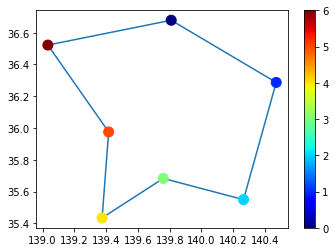

In [33]:
import matplotlib.pyplot as plt

# extract lowest energy state
x = decoded.feasibles()[0][0]['x']
print(x)
print(decoded.feasibles()[0][4])
# visualize solution
tsp_path = np.where(x==1)[1]
tsp_path = np.append(tsp_path, tsp_path[0])
lat_list = [latlng_list[i][0] for i in range(len(latlng_list))]
lng_list = [latlng_list[i][1] for i in range(len(latlng_list))]
plt.axes().set_aspect('equal')
len_path = len(tsp_path)
route = []
xx = []
yy = []
for i in range(len_path):
    route.append(points[tsp_path[i]])
    xx.append(lng_list[tsp_path[i]])
    yy.append(lat_list[tsp_path[i]])
plt.plot(xx, yy, zorder=1)
print(route)
del xx[-1]
del yy[-1]
cmap = plt.cm.get_cmap('jet')
z = range(len(xx))
sc = plt.scatter(xx, yy, c=z, cmap=cmap, zorder=2, s=100)
plt.colorbar(sc)
plt.show()

制約項(penalty)が2つとも0になっていることがわかります。また今回の計算で選ばれた旅程は、例えば千葉→東京→神奈川→埼玉→群馬→栃木→茨城→千葉のように、関東一都六県をぐるっと一周するような経路となりました。

# 結言

今回はVRPなど様々に応用できるTSPを題材に、JijModelingとJijZeptの使い方をご紹介しました。以下に要点をまとめます。

- $\sum_t x_{t, i}$はx[:, i]のように簡略化することができる。
- $\sum_t \sum_i \sum_j$のように総和が並んでいる場合には、JijModelingでは簡略化して1つのSum([{...}, {...}, {...}], ...)で記述することができる。
- Element()を用いることで、算術演算可能な添字を作ることができる。
- JijZeptに問題を解かせる際に、num_readsやnum_sweepsでアニーリングパラメータを変更することができる。

これらを活用して計算困難な問題を美しく実装し、最適解発見までをシームレスに行いましょう。

# 参考文献

[1] 西森秀稔, 大関真之, "量子アニーリングの基礎"  
[2] [Feld et al., 2018, "A Hybrid Solution Method for the Capacitated Vehicle Routing Problem Using a Quantum Annealer"](https://www.frontiersin.org/articles/10.3389/fict.2019.00013/full)  
[3] [Harikrishnakumar et al., 2020, "A Quantum Annealing Approach for Dynamic Multi-Depot Capacitated Vehicle Routing Problem"](https://arxiv.org/abs/2005.12478)  
[4] [Irie et al., 2019, "Quantum Annealing of Vehicle Routing Problem with Time, State and Capacity"](https://doi.org/10.1007/978-3-030-14082-3_13)